# <b>AASD 4015 - Advance Mathematical Concepts for Deep Learning Group Project 2</b>

<b>Members:</b> 
1. Saksham Prakash (101410709) 
2. Sik Yin Sun (101409665)

## Background and Motivation

## <b> 1. Installing and Importing libraries </b>
<a id='lib'></a>

In [32]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, inception_v3, efficientnet_v2
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Model

## <b>2. Data - Chest X-Ray Images (Pneumonia)</b>
<font size=3>The link of Data:</font>
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [3]:
train_dir = "../chest_xray/train"
val_dir = "../chest_xray/val"
test_dir = "../chest_xray/test"

In [4]:
img_height = 320
img_width = 320
batch_size = 16

In [5]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size=(img_height, img_width), batch_size = batch_size, shuffle = True)
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir, image_size=(img_height, img_width), batch_size = batch_size, shuffle = True)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=(img_height, img_width), batch_size = batch_size, shuffle = True)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [6]:
class_label = train_data.class_names
class_label

['NORMAL', 'PNEUMONIA']

In [7]:
train_num = []
val_num = []
test_num = []
print("Train Data")
for i in class_label:
    num_files = len(os.listdir(os.path.join(train_dir, i)))
    train_num.append(num_files)
    print(f"{i}: {num_files} files")

print("\nValidation Data")
for i in class_label:
    num_files = len(os.listdir(os.path.join(val_dir, i)))
    val_num.append(num_files)
    print(f"{i}: {num_files} files")

print("\nTest Data")
for i in class_label:
    num_files = len(os.listdir(os.path.join(test_dir, i)))
    test_num.append(num_files)
    print(f"{i}: {num_files} files")

Train Data
NORMAL: 1341 files
PNEUMONIA: 3875 files

Validation Data
NORMAL: 8 files
PNEUMONIA: 8 files

Test Data
NORMAL: 234 files
PNEUMONIA: 390 files


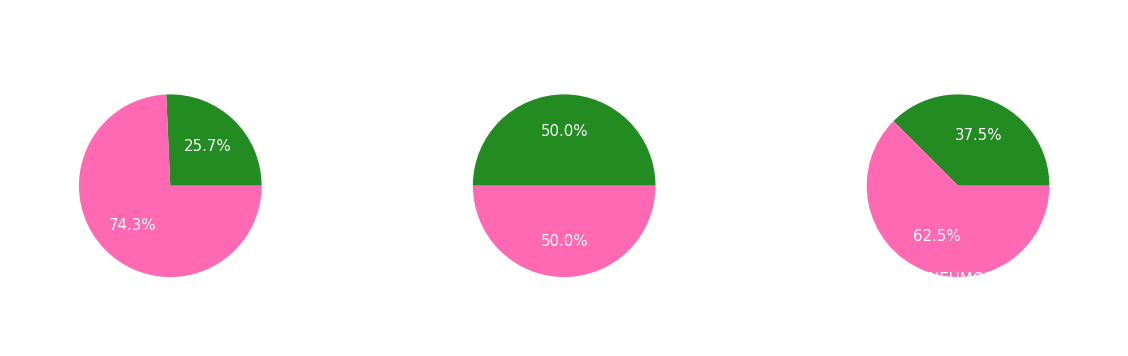

In [9]:
colors = ['#228b22', '#ff69b4']
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))
axs[0].pie(train_num, labels=class_label, autopct='%1.1f%%', colors = colors, textprops={'color': 'white', 'fontsize': 15}, radius=0.7, center=(0.5, 0.5))
axs[0].set_title('Distribution of Images Across Classes for Train Data', color="white")
axs[1].pie(val_num, labels=class_label, autopct='%1.1f%%', colors = colors, textprops={'color': 'white', 'fontsize': 15}, radius=0.7, center=(0.5, 0.5))
axs[1].set_title('Distribution of Images Across Classes for Validation Data', color="white")
axs[2].pie(test_num, labels=class_label, autopct='%1.1f%%', colors = colors, textprops={'color': 'white', 'fontsize': 15}, radius=0.7, center=(0.5, 0.5))
axs[2].set_title('Distribution of Images Across Classes for Test Data', color="white")
plt.show()

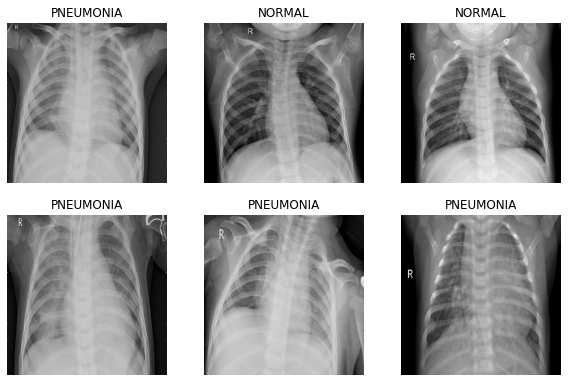

In [10]:
plt.figure(figsize = (10,10))
for images, labels in train_data.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_label[labels[i]])
    plt.axis('off')

<font size=3>After briefly exploring the data, we found out that there is a vast difference between "normal" and "pneumonia" for the train data. Additionally, we found that there is more pneumonia record than normal. From the image above, we can see them for people with pneumonia. Their X-ray pictures are much blurry than normal people, and we believe that is because the lung infection causes some fluid there.</font>

## <b> 3.1 VGG </b>

In [11]:
image_size = (img_height, img_width,3) 

In [14]:
vgg16 = VGG16(include_top = False, weights = 'imagenet',input_shape = image_size)

# freeze the vgg16 and create our own head
for layer in vgg16.layers:
    layer.trainable = False
    
x = Flatten()(vgg16.output)
x = Dense(1, activation="sigmoid")(x)

vgg16 = Model(inputs=vgg16.input, outputs=x)
vgg16.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])# binary cross entropy loss function is used for binary classification

In [15]:
history = vgg16.fit(train_data, epochs=20,validation_data = val_data)

Epoch 1/20
326/326 [==============================] - 54s 121ms/step - loss: 1.4232 - accuracy: 0.9534 - val_loss: 1.1282 - val_accuracy: 0.8750
Epoch 2/20
326/326 [==============================] - 39s 120ms/step - loss: 0.3549 - accuracy: 0.9887 - val_loss: 2.3591e-22 - val_accuracy: 1.0000
Epoch 3/20
326/326 [==============================] - 37s 113ms/step - loss: 0.2849 - accuracy: 0.9902 - val_loss: 0.8019 - val_accuracy: 0.9375
Epoch 4/20
326/326 [==============================] - 40s 122ms/step - loss: 0.2607 - accuracy: 0.9933 - val_loss: 3.9558e-08 - val_accuracy: 1.0000
Epoch 5/20
326/326 [==============================] - 37s 112ms/step - loss: 0.1309 - accuracy: 0.9933 - val_loss: 8.3182e-19 - val_accuracy: 1.0000
Epoch 6/20
326/326 [==============================] - 37s 111ms/step - loss: 0.0627 - accuracy: 0.9971 - val_loss: 2.1827e-07 - val_accuracy: 1.0000
Epoch 7/20
326/326 [==============================] - 37s 111ms/step - loss: 0.1293 - accuracy: 0.9952 - val_loss:

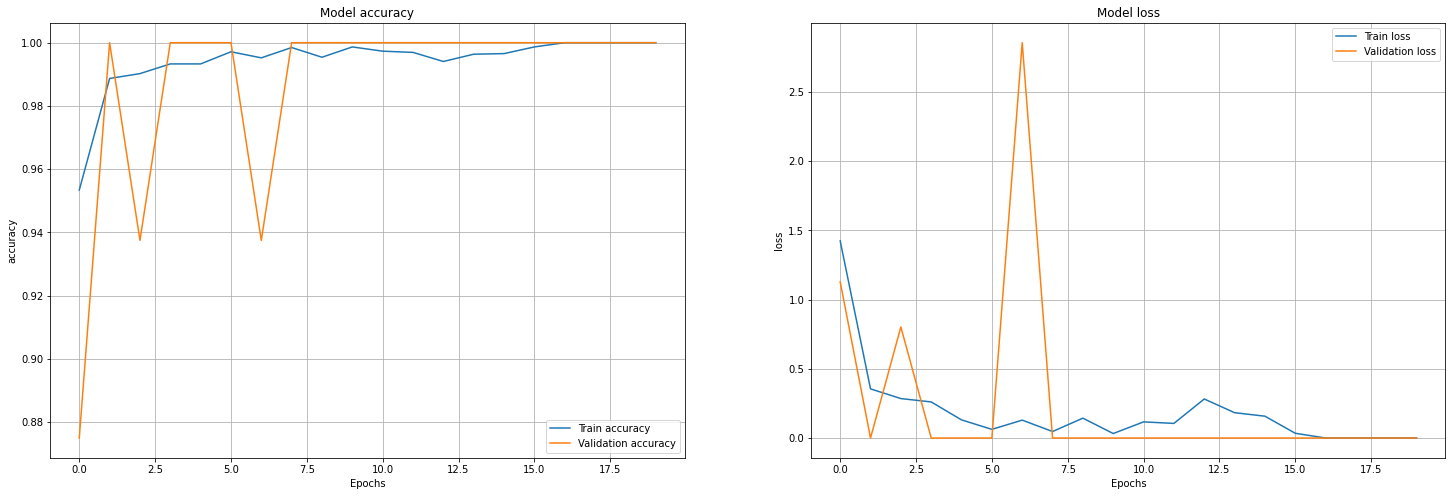

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(25, 8))

ax[0].plot(history.history['accuracy'], label="Train accuracy")
ax[0].plot(history.history['val_accuracy'], label="Validation accuracy")
ax[0].set_title("Model accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("accuracy")
ax[0].legend(["train", "val"])
ax[0].grid(True)
ax[0].legend()

ax[1].plot(history.history['loss'], label="Train loss")
ax[1].plot(history.history['val_loss'], label="Validation loss")
ax[1].set_title("Model loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("loss")
ax[1].legend(["train", "val"])
ax[1].grid(True)
ax[1].legend()

plt.show()

### Maybe adding confusion Matrix and Classification???

## <b> 3.2 InceptionV3 </b>

In [28]:
iv3 = inception_v3.InceptionV3(include_top = False, weights = 'imagenet',input_shape = image_size)

# freeze the vgg16 and create our own head
for layer in iv3.layers:
    layer.trainable = False
    
x = Flatten()(iv3.output)
x = Dense(1, activation="sigmoid")(x)

iv3 = Model(inputs=iv3.input, outputs=x)
iv3.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])# binary cross entropy loss function is used for binary classification

87910968/87910968 [==============================] - 2s 0us/step


In [30]:
history_iv3 = iv3.fit(train_data, epochs=20,validation_data = val_data)

Epoch 1/20
326/326 [==============================] - 27s 82ms/step - loss: 8.1393 - accuracy: 0.9576 - val_loss: 18.4954 - val_accuracy: 0.8750
Epoch 2/20
326/326 [==============================] - 24s 74ms/step - loss: 9.1972 - accuracy: 0.9582 - val_loss: 130.0177 - val_accuracy: 0.5625
Epoch 3/20
326/326 [==============================] - 24s 73ms/step - loss: 6.1502 - accuracy: 0.9693 - val_loss: 198.9117 - val_accuracy: 0.5625
Epoch 4/20
326/326 [==============================] - 24s 74ms/step - loss: 7.1674 - accuracy: 0.9697 - val_loss: 216.6636 - val_accuracy: 0.6250
Epoch 5/20
326/326 [==============================] - 24s 73ms/step - loss: 5.6174 - accuracy: 0.9747 - val_loss: 206.3827 - val_accuracy: 0.5625
Epoch 6/20
326/326 [==============================] - 24s 73ms/step - loss: 7.0157 - accuracy: 0.9720 - val_loss: 375.3767 - val_accuracy: 0.6250
Epoch 7/20
326/326 [==============================] - 24s 74ms/step - loss: 4.5122 - accuracy: 0.9810 - val_loss: 106.7922 - 

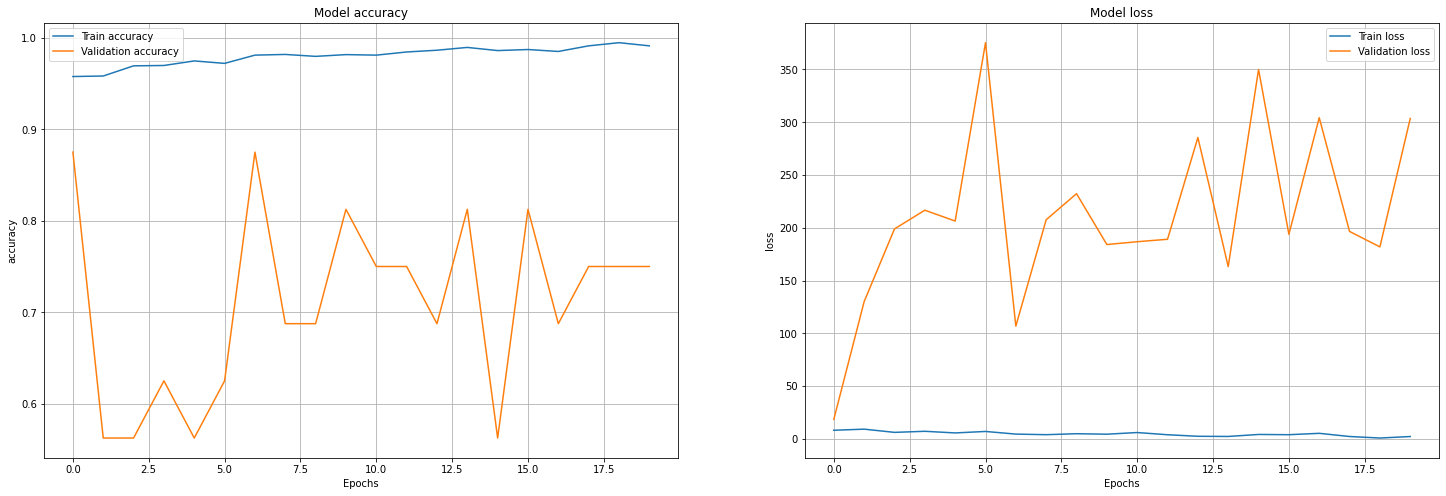

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(25, 8))

ax[0].plot(history_iv3.history['accuracy'], label="Train accuracy")
ax[0].plot(history_iv3.history['val_accuracy'], label="Validation accuracy")
ax[0].set_title("Model accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("accuracy")
ax[0].legend(["train", "val"])
ax[0].grid(True)
ax[0].legend()

ax[1].plot(history_iv3.history['loss'], label="Train loss")
ax[1].plot(history_iv3.history['val_loss'], label="Validation loss")
ax[1].set_title("Model loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("loss")
ax[1].legend(["train", "val"])
ax[1].grid(True)
ax[1].legend()

plt.show()

## <b> 3.3 EffientNetV2B3 </b>

In [33]:
eff_v2 = efficientnet_v2.EfficientNetV2B3(include_top = False, weights = 'imagenet',input_shape = image_size)

# freeze the vgg16 and create our own head
for layer in eff_v2.layers:
    layer.trainable = False
    
x = Flatten()(eff_v2.output)
x = Dense(1, activation="sigmoid")(x)

eff_v2 = Model(inputs=eff_v2.input, outputs=x)
eff_v2.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])# binary cross entropy loss function is used for binary classification

52606240/52606240 [==============================] - 1s 0us/step


In [34]:
history_eff_v2 = eff_v2.fit(train_data, epochs=20,validation_data = val_data)

Epoch 1/20
326/326 [==============================] - 45s 105ms/step - loss: 0.6784 - accuracy: 0.9519 - val_loss: 0.6911 - val_accuracy: 0.9375
Epoch 2/20
326/326 [==============================] - 31s 96ms/step - loss: 0.3376 - accuracy: 0.9755 - val_loss: 2.5561e-11 - val_accuracy: 1.0000
Epoch 3/20
326/326 [==============================] - 32s 96ms/step - loss: 0.2181 - accuracy: 0.9854 - val_loss: 8.6792e-20 - val_accuracy: 1.0000
Epoch 4/20
326/326 [==============================] - 31s 96ms/step - loss: 0.2082 - accuracy: 0.9856 - val_loss: 5.5913e-05 - val_accuracy: 1.0000
Epoch 5/20
326/326 [==============================] - 31s 96ms/step - loss: 0.2595 - accuracy: 0.9845 - val_loss: 3.2605e-31 - val_accuracy: 1.0000
Epoch 6/20
326/326 [==============================] - 31s 96ms/step - loss: 0.1379 - accuracy: 0.9921 - val_loss: 0.7562 - val_accuracy: 0.9375
Epoch 7/20
326/326 [==============================] - 31s 95ms/step - loss: 0.1491 - accuracy: 0.9921 - val_loss: 1.088

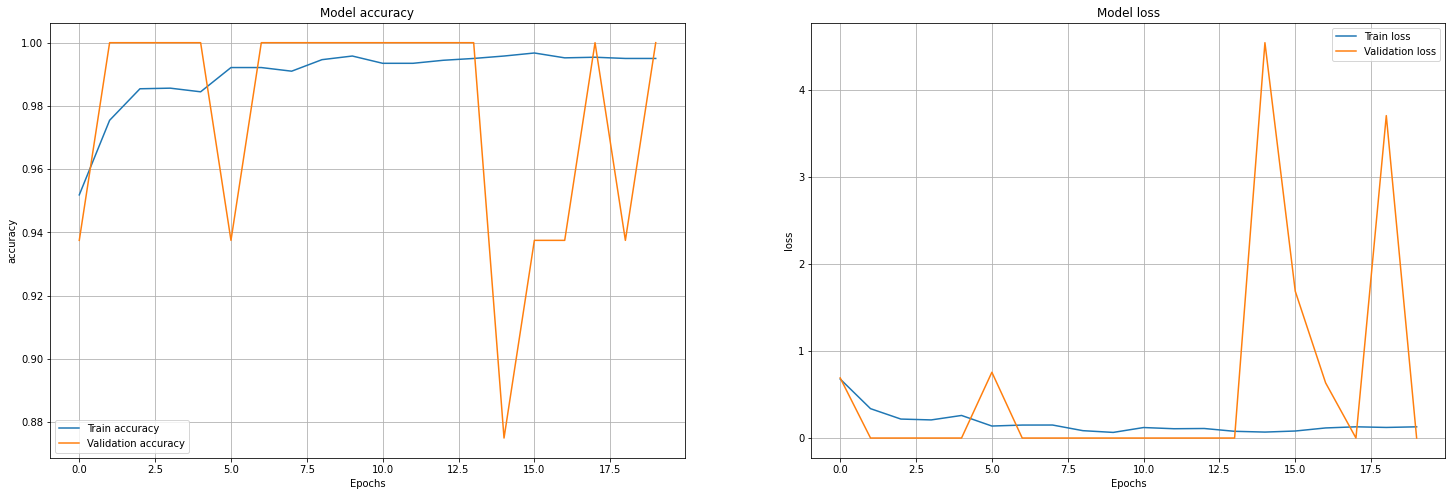

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(25, 8))

ax[0].plot(history_eff_v2.history['accuracy'], label="Train accuracy")
ax[0].plot(history_eff_v2.history['val_accuracy'], label="Validation accuracy")
ax[0].set_title("Model accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("accuracy")
ax[0].legend(["train", "val"])
ax[0].grid(True)
ax[0].legend()

ax[1].plot(history_eff_v2.history['loss'], label="Train loss")
ax[1].plot(history_eff_v2.history['val_loss'], label="Validation loss")
ax[1].set_title("Model loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("loss")
ax[1].legend(["train", "val"])
ax[1].grid(True)
ax[1].legend()

plt.show()